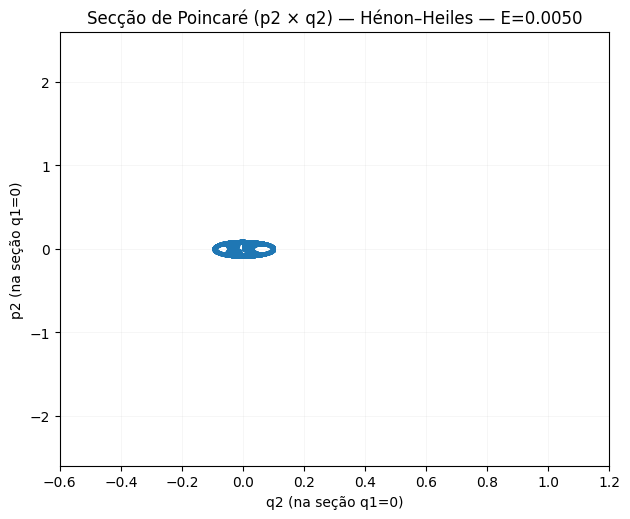

[E=0.0050] pontos:  58552  →  salvo: figs/compressed_pss_h0.0.0050.png


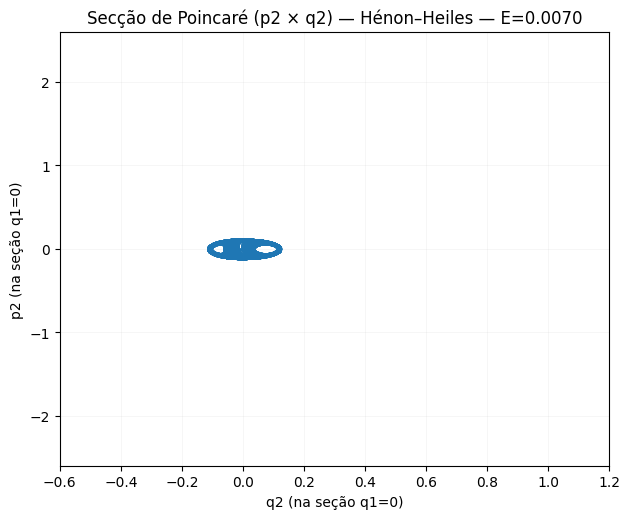

[E=0.0070] pontos:  58435  →  salvo: figs/compressed_pss_h0.0.0070.png


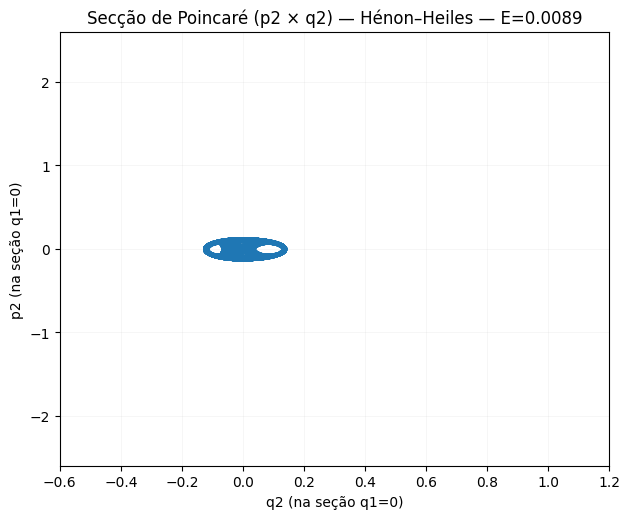

[E=0.0089] pontos:  59565  →  salvo: figs/compressed_pss_h0.0.0089.png


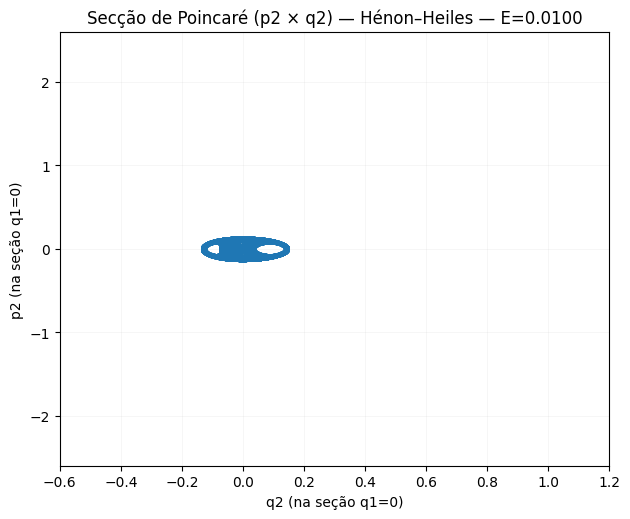

[E=0.0100] pontos:  58689  →  salvo: figs/compressed_pss_h0.0.0100.png


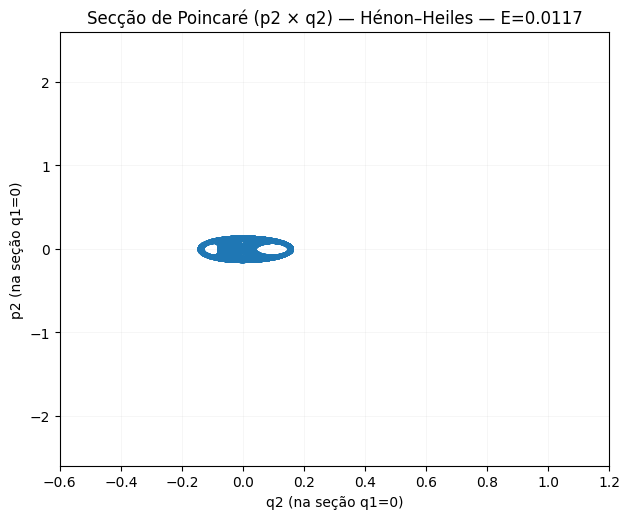

[E=0.0117] pontos:  59200  →  salvo: figs/compressed_pss_h0.0.0117.png


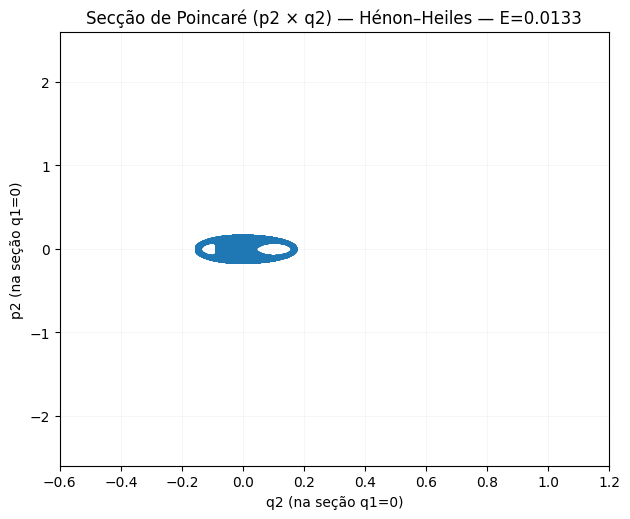

[E=0.0133] pontos:  58901  →  salvo: figs/compressed_pss_h0.0.0133.png


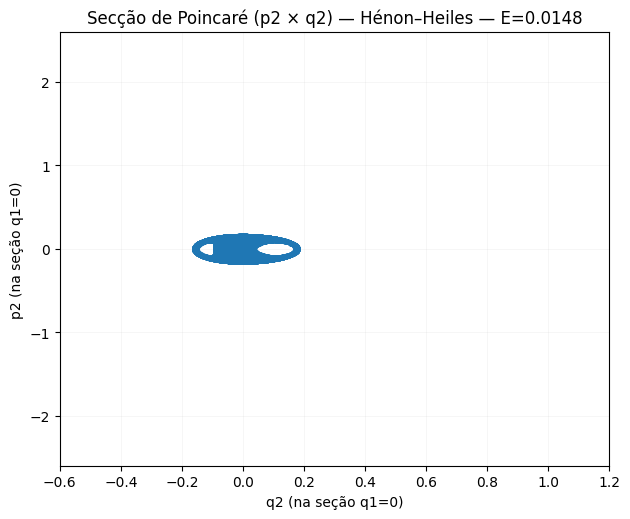

[E=0.0148] pontos:  57983  →  salvo: figs/compressed_pss_h0.0.0148.png


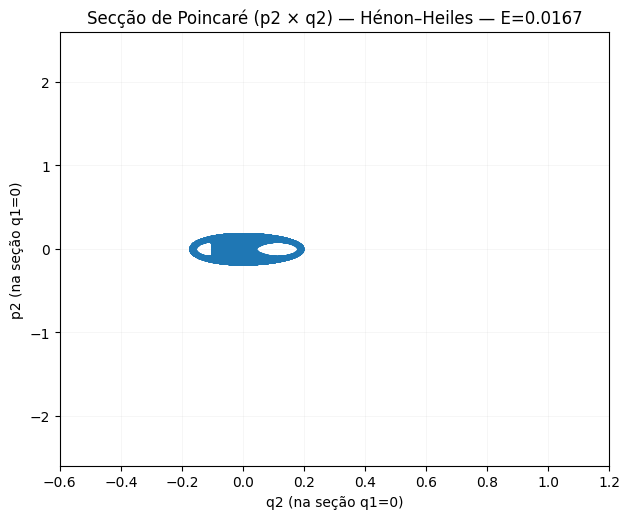

[E=0.0167] pontos:  59096  →  salvo: figs/compressed_pss_h0.0.0167.png


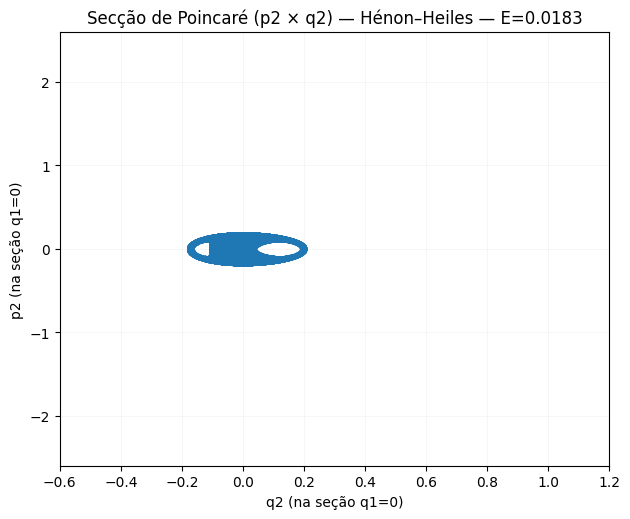

[E=0.0183] pontos:  58214  →  salvo: figs/compressed_pss_h0.0.0183.png


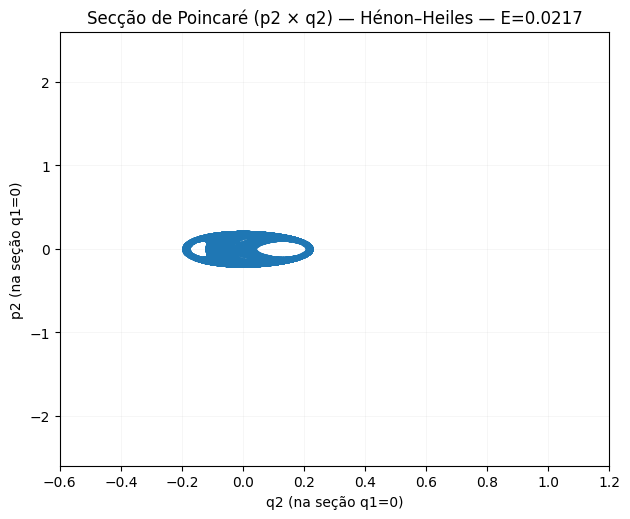

[E=0.0217] pontos:  58443  →  salvo: figs/compressed_pss_h0.0.0217.png


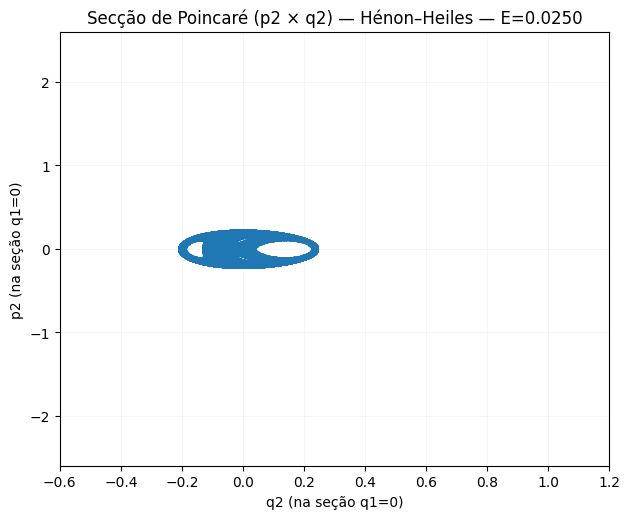

[E=0.0250] pontos:  59247  →  salvo: figs/compressed_pss_h0.0.0250.png


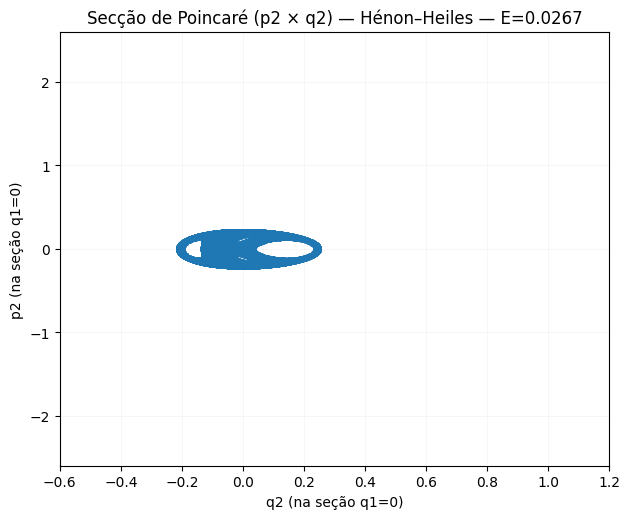

[E=0.0267] pontos:  60332  →  salvo: figs/compressed_pss_h0.0.0267.png


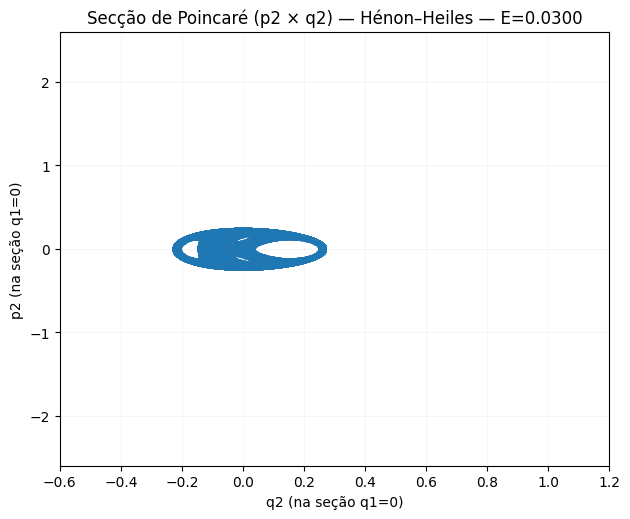

[E=0.0300] pontos:  59181  →  salvo: figs/compressed_pss_h0.0.0300.png


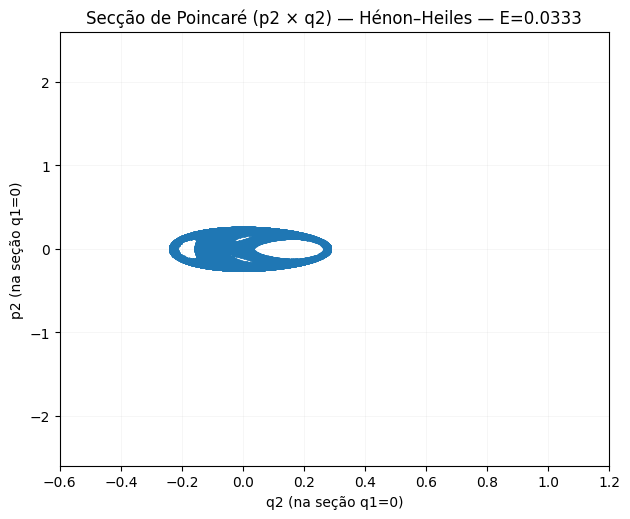

[E=0.0333] pontos:  59996  →  salvo: figs/compressed_pss_h0.0.0333.png


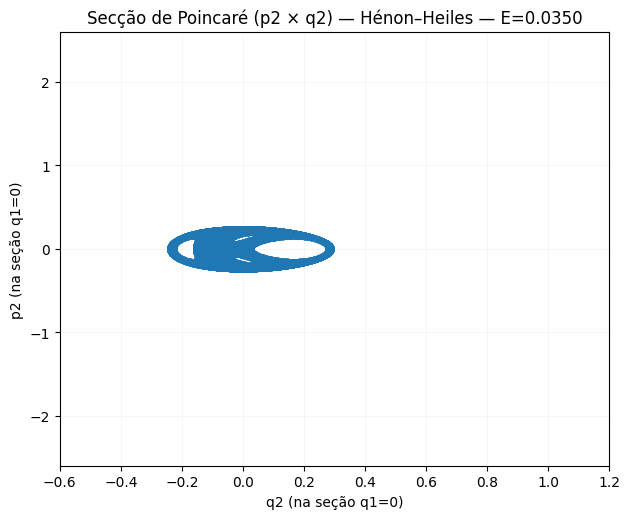

[E=0.0350] pontos:  57653  →  salvo: figs/compressed_pss_h0.0.0350.png


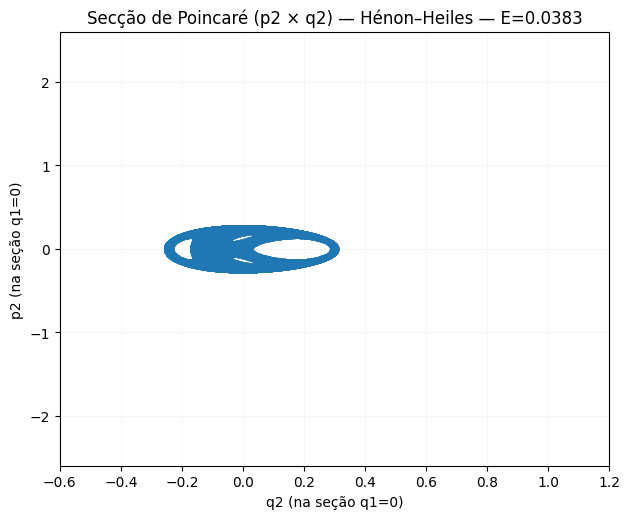

[E=0.0383] pontos:  60790  →  salvo: figs/compressed_pss_h0.0.0383.png


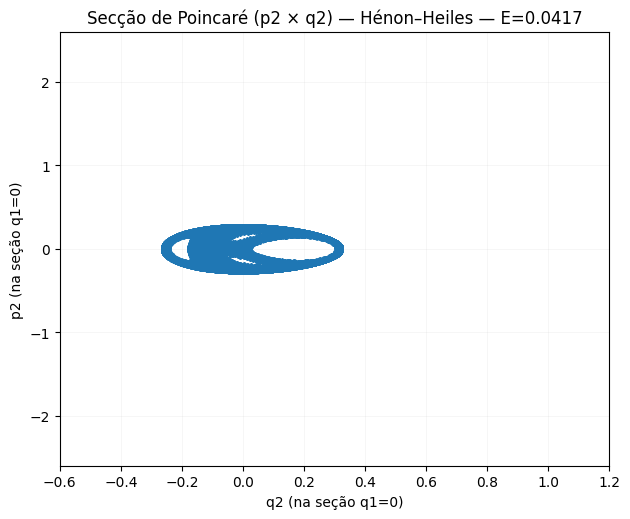

[E=0.0417] pontos:  59915  →  salvo: figs/compressed_pss_h0.0.0417.png


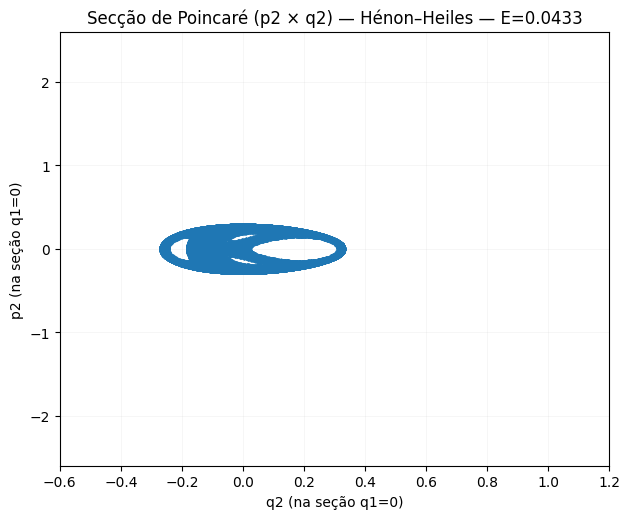

[E=0.0433] pontos:  61064  →  salvo: figs/compressed_pss_h0.0.0433.png


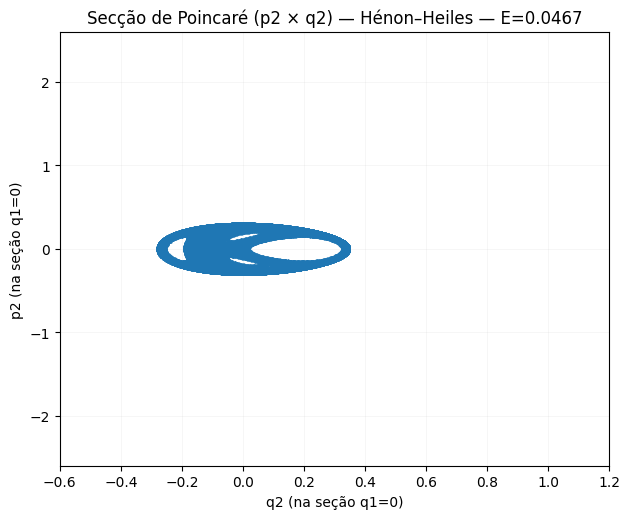

[E=0.0467] pontos:  59347  →  salvo: figs/compressed_pss_h0.0.0467.png


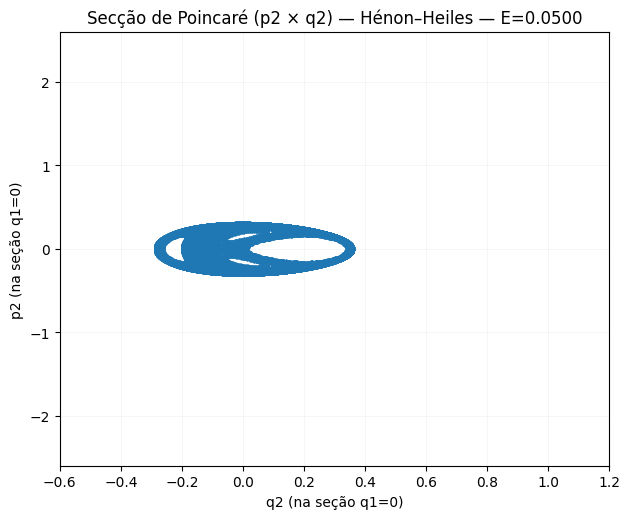

[E=0.0500] pontos:  59336  →  salvo: figs/compressed_pss_h0.0.0500.png


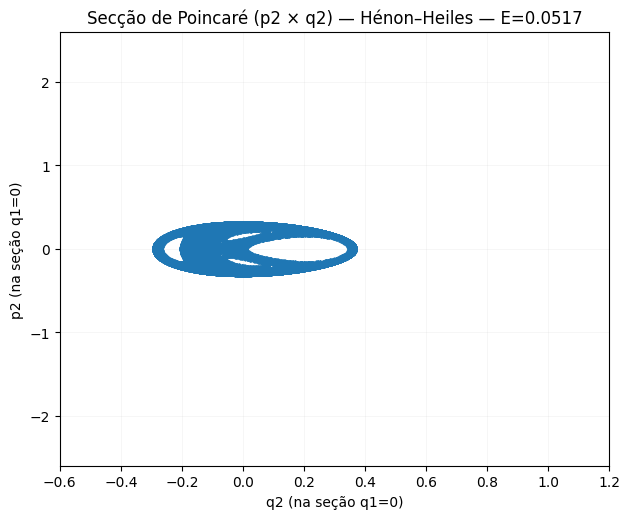

[E=0.0517] pontos:  59920  →  salvo: figs/compressed_pss_h0.0.0517.png


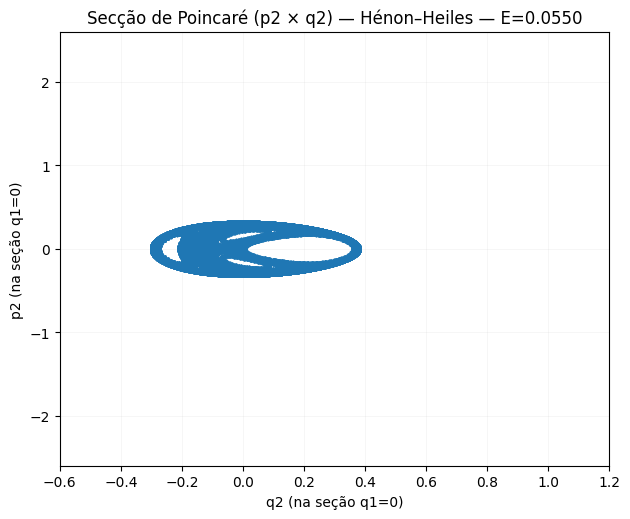

[E=0.0550] pontos:  60785  →  salvo: figs/compressed_pss_h0.0.0550.png


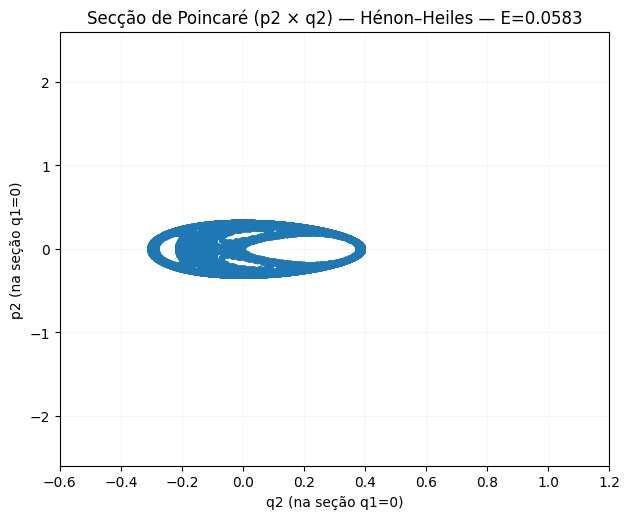

[E=0.0583] pontos:  61988  →  salvo: figs/compressed_pss_h0.0.0583.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- (1) Sistema HH: já tínhamos essas funções ---
def U_grad(q1, q2):
    dU_dq1 = q1 + 2.0*q1*q2
    dU_dq2 = q2 + q1*q1 - q2*q2
    return dU_dq1, dU_dq2

def H(q1,q2,p1,p2):
    return 0.5*(p1*p1 + p2*p2 + q1*q1 + q2*q2) + q1*q1*q2 - (1.0/3.0)*q2*q2*q2

def euler_symplectic_step(q1,q2,p1,p2, dt):
    q1_next = q1 + dt*p1
    q2_next = q2 + dt*p2
    dU1, dU2 = U_grad(q1_next, q2_next)
    p1_next = p1 - dt*dU1
    p2_next = p2 - dt*dU2
    return q1_next, q2_next, p1_next, p2_next

def integrar_HH_symplectic(q1,q2,p1,p2, dt, T):
    n = int(np.ceil(T/dt))
    Q1 = np.empty(n+1); Q2 = np.empty(n+1); P1 = np.empty(n+1); P2 = np.empty(n+1)
    Q1[0]=q1; Q2[0]=q2; P1[0]=p1; P2[0]=p2
    for k in range(n):
        q1,q2,p1,p2 = euler_symplectic_step(q1,q2,p1,p2, dt)
        Q1[k+1]=q1; Q2[k+1]=q2; P1[k+1]=p1; P2[k+1]=p2
    return Q1,Q2,P1,P2

def section_q1_zero_henon(q1,q2,p1,p2, dt, T, max_points=1500):
    """coleta pontos (q2*,p2*) na seção q1=0, orientação p1*>=0, via interpolação de Hénon"""
    q2_pts, p2_pts = [], []
    Q1,Q2,P1,P2 = integrar_HH_symplectic(q1,q2,p1,p2, dt, T)
    for k in range(len(Q1)-1):
        if len(q2_pts) >= max_points:
            break
        q1a, q1b = Q1[k], Q1[k+1]
        if q1a*q1b < 0.0:
            # derivadas no ponto k:
            fq1 = P1[k]                    # dq1/dt
            if abs(fq1) < 1e-14:           # evita degenerescência
                continue
            dU1, dU2 = U_grad(Q1[k], Q2[k])
            dq2_dq1 = P2[k]/fq1
            dp1_dq1 = - dU1 / fq1
            dp2_dq1 = - dU2 / fq1
            # "passo" em q1 necessário pra chegar q1=0:
            Dq1 = - q1a
            # valores na seção:
            q2_star  = Q2[k] + Dq1 * dq2_dq1
            p1_star  = P1[k] + Dq1 * dp1_dq1
            p2_star  = P2[k] + Dq1 * dp2_dq1
            if p1_star >= 0.0:
                q2_pts.append(q2_star); p2_pts.append(p2_star)
    return np.asarray(q2_pts), np.asarray(p2_pts)

# --- (2) Gerar ICs NA ENERGIA (na seção) ---
def admissible_q2_interval(E, margin=1e-6):
    """
    Para q1=0, p1>=0, p2 real:
    p2^2 = 2E - (q2^2 + p1^2) + (2/3) q2^3  >= 0  (com p1>0 pequeno)
    Limites brutos de q2 resolvendo p2^2 >= 0 com p1≈0.
    """
    # malha grossa e filtro por p2^2>=0 (p1≈0)
    q2 = np.linspace(-0.6, 1.2, 2000)
    rad = 2*E - q2*q2 + (2.0/3.0)*q2*q2*q2
    mask = rad >= 0.0
    if not np.any(mask):
        return 0.0, 0.0
    q2_adm = q2[mask]
    return q2_adm.min()+margin, q2_adm.max()-margin

def ic_sampler_on_section(E, n_q2=18, n_p1=8, p1_min=0.02, p1_max_frac=0.7, eps=1e-6):
    """
    Retorna uma lista de ICs (q1,q2,p1,p2) na energia E, todos com q1=-eps (para cruzar logo).
    Varre q2 e p1; calcula p2 = ± sqrt(R - p1^2).
    """
    q2min, q2max = admissible_q2_interval(E)
    q2_grid = np.linspace(q2min, q2max, n_q2)
    ics = []
    for q2 in q2_grid:
        R = 2*E - q2*q2 + (2.0/3.0)*q2*q2*q2   # p1^2 + p2^2 <= R
        if R <= 0:
            continue
        p1_max = np.sqrt(R) * p1_max_frac
        p1_grid = np.linspace(p1_min, p1_max, n_p1)
        for p1 in p1_grid:
            rem = R - p1*p1
            if rem <= 0:
                continue
            p2mag = np.sqrt(rem)
            # use os dois sinais de p2 para "encher" a figura
            ics.append( (-eps, q2, p1, +p2mag) )
            ics.append( (-eps, q2, p1, -p2mag) )
    return ics

# --- (3) Plot bonito e salvamento ---
def plot_and_save_section(points_q2, points_p2, E, fname, xlim=(-0.6,1.2), ylim=(-2.6,2.6)):
    plt.figure(figsize=(6.4,5.3))
    plt.plot(points_q2, points_p2, '.', ms=1.25)
    plt.xlim(*xlim); plt.ylim(*ylim)
    plt.xlabel('q2 (na seção q1=0)'); plt.ylabel('p2 (na seção q1=0)')
    plt.title(f'Secção de Poincaré (p2 × q2) — Hénon–Heiles — E={E:.4f}')
    plt.grid(alpha=0.15, lw=0.5)
    plt.tight_layout()
    plt.savefig(fname, dpi=260)
    plt.show()

# --- (4) Varra as energias do professor e gere as figuras ---
def run_many_energies(E_list, dt=5e-4, T=800.0, N_target=500, outdir='figs'):
    import os
    os.makedirs(outdir, exist_ok=True)

    for E in E_list:
        # gera várias ICs no mesmo E
        ICs = ic_sampler_on_section(E, n_q2=22, n_p1=10, p1_min=0.02, p1_max_frac=0.75, eps=1e-6)
        all_q2, all_p2 = [], []
        # integre cada IC até coletar N_target cruzamentos (ou acabar T)
        for (q1,q2,p1,p2) in ICs:
            q2_pts, p2_pts = section_q1_zero_henon(q1,q2,p1,p2, dt, T, max_points=N_target//4)
            if len(q2_pts):
                all_q2.append(q2_pts); all_p2.append(p2_pts)
        if not all_q2:
            print(f'[E={E:.4f}] nenhum ponto coletado (tente aumentar p1_min/p1_max_frac/T).')
            continue
        Q2 = np.concatenate(all_q2); P2 = np.concatenate(all_p2)

        # nome no padrão "compressed_pss_h0.xxxx.png"
        tag = f'{E:.4f}'.replace('0.', '0.')  # mantém 4 casas
        fname = f'{outdir}/compressed_pss_h0.{tag}.png'
        plot_and_save_section(Q2, P2, E, fname)
        print(f'[E={E:.4f}] pontos: {len(Q2):6d}  →  salvo: {fname}')

# === Energies da lista do professor (exemplos; ajuste ao que você tem) ===
E_list = [
    0.0050, 0.0070, 0.0089, 0.0100, 0.0117, 0.0133, 0.0148, 0.0167, 0.0183,
    0.0217, 0.0250, 0.0267, 0.0300, 0.0333, 0.0350, 0.0383, 0.0417, 0.0433,
    0.0467, 0.0500, 0.0517, 0.0550, 0.0583, 0.0600, 0.0633, 0.0667, 0.0683,
    0.0717, 0.0750, 0.0767, 0.0800, 0.0833, 0.0850, 0.0883, 0.0917, 0.0933,
    0.0967, 0.1000, 0.1017, 0.1050, 0.1083, 0.1100, 0.1133, 0.1167, 0.1183,
    0.1217, 0.1250, 0.1267, 0.1300, 0.1333, 0.1350, 0.1383, 0.1417, 0.1433,
    0.1467, 0.1500, 0.1517, 0.1550, 0.1583, 0.1600, 0.1633, 0.1667
]

# rode!
run_many_energies(E_list, dt=5e-4, T=900.0, N_target=1200, outdir='figs')